# LangGraph 101: Building Your First Agent

Welcome to LangGraph 101! This notebook will walk you through the core concepts of building agents with LangChain and LangGraph.

**What you'll learn:**
- How to interact with language models
- Working with messages and conversation
- Adding tools to extend LLM capabilities
- Building an agent that can reason and act
- Adding memory to maintain context
- Streaming responses for better UX
<br> 
<br> 
---
<br> 

> **Note:** This tutorial uses LangChain v1 (alpha), which provides the easiest way to start building with LLMs. LangChain agents are built on top of LangGraph, providing durable execution, streaming, human-in-the-loop, and persistence out of the box.

## Part 0: Setup & Installation

First, let's install the necessary packages and set up our environment.

In [19]:
# Install required packages
# !pip install --pre -U langchain langchain-anthropic langchain-openai python-dotenv

In [20]:
# Load environment variables
from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env", override=True)

# We'll use OpenAI in this tutorial, but you can swap to any provider!
# Supported providers: OpenAI, Anthropic, Google, Cohere, and many more

True

## Part 1: Your First LLM Call

LangChain provides a **standard model interface** that works across all providers. This means you can easily swap between OpenAI, Anthropic, Google, and other providers without changing your code.

Let's start by initializing a chat model.

In [21]:
from langchain.chat_models import init_chat_model

# Initialize a chat model - you can easily swap providers!
# Examples: "openai:gpt-5-nano", "anthropic:claude-3-7-sonnet-latest", "google:gemini-2.0-flash"
model = init_chat_model("openai:gpt-5-nano")

# Make your first call!
response = model.invoke("What is LangChain?")
response.pretty_print()

================================== Ai Message ==================================

LangChain is an open‑source framework for building applications that use large language models (LLMs). It provides the building blocks you need to connect LLMs to data, tools, and multi-step workflows, so you can create robust AI assistants, chatbots, and automation.

Key ideas and components:
- Chains: sequences of prompts and LLM calls to perform multi-step reasoning.
- Prompt templates: reusable prompts that plug in variables.
- Agents and tools: agents decide actions and can call external tools or APIs (e.g., search, calculators, code execution, database queries).
- Memory: store and reuse context from previous interactions (conversation history, summaries).
- Vector stores: manage embeddings for retrieval-augmented generation (RAG) over documents or data sources.
- Prompts, callbacks, and evaluation: structured ways to manage prompts, track events, and assess outputs.
- Language support: LangChain ha

### Key Takeaway:
- `init_chat_model()` gives you a standardized interface to any LLM provider
- `.invoke()` sends a message and returns a response
- No provider lock-in - swap models easily!

## Part 2: Understanding Messages

**Messages** are the fundamental unit of context for models in LangChain. They represent the input and output of models, carrying both content and metadata.

There are different message types:
- **SystemMessage** - Instructions for how the model should behave
- **HumanMessage** - User input
- **AIMessage** - Model responses
- **ToolMessage** - Results from tool executions

In [22]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# Create a conversation with different message types
messages = [
    SystemMessage(content="You are a helpful AI assistant that explains technical concepts simply."),
    HumanMessage(content="What is an agent?"),
]

response = model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

An agent is something that can perceive its environment, make decisions, and take actions to achieve goals.

In AI terms:
- It’s often a program or robot.
- It observes the world with sensors (or inputs), reasons about what to do, and acts with actuators (or outputs).

Key ideas:
- Autonomy: it can run on its own without constant instructions.
- Perception: it observes the environment.
- Action: it can affect the environment.
- Goal or objective: it tries to do something specific, sometimes optimizing a task or outcome.
- Sometimes learning or adapting over time.

Types and examples:
- Software agents: web crawlers, spam filters, chatbots.
- Robotic agents: a vacuum robot, a drone.
- Multi-agent systems: several agents that coordinate or compete.

Simple examples:
- Thermostat: senses temperature, aims to keep it at a setpoint, turns the heater on/off.
- Vacuum robot: senses dirt and obstacles, aims to cl

### Multi-turn Conversations

Messages make it easy to maintain conversation history:

In [23]:
# Continue the conversation
messages.append(response)  # Add AI response to history
messages.append(HumanMessage(content="Can you give me an example?"))

response = model.invoke(messages)
response.pretty_print()

================================== Ai Message ==================================

Here’s a concrete example of an agent:

Example: Smart garden irrigation controller

- Perception (sensors/inputs): soil moisture sensors, current time, weather forecast, valve status.
- Decision-making (reasoning): based on moisture level and forecast, decide whether to water and for how long.
- Action (actuators): open/close irrigation valves for a set duration.
- Goal: keep the garden plants healthy while saving water.
- Autonomy: runs on its own after setup; doesn’t need constant instructions.
- Learning/adaptation: can adjust moisture targets for different plants or seasons based on past results.

How it works in practice:
- If the soil is dry and rain isn’t forecasted, the agent turns on the sprinklers for 15 minutes.
- If the soil is already moist or rain is expected soon, it does nothing.
- Over time, it learns that certain plants need more water and adjusts targets accordingly.

If you want, I ca

### Key Takeaway:
- Messages represent the conversation history
- SystemMessage sets the model's behavior
- Build multi-turn conversations by appending messages to a list

## Part 3: Adding Tools - Extending LLM Capabilities

LLMs are great at language, but they can't access external data or perform actions. **Tools** extend their capabilities. You can give an LLM a list of tools, and when it needs one, it will specify which tool to call. Your job is to execute the tool and feed the results back to the LLM so it can decide what to do next.

You can create a tool just by writing a Python function with a clear description. LangChain's `@tool` decorator handles formatting the function's information in the LLM's desired format.  

Let's create some simple tools:

In [24]:
import requests
import json

from langchain_core.tools import tool


# Basic hardcoded tool
@tool
def search_movies(genre: str) -> str:
    """Search for movies by genre."""
    # In a real app, this would query a movie database
    movies = {
        "sci-fi": "Dune, Interstellar, Blade Runner 2049",
        "comedy": "The Grand Budapest Hotel, Superbad, Knives Out",
        "action": "Mad Max: Fury Road, John Wick, Mission Impossible"
    }
    return movies.get(genre.lower(), "No movies found for that genre")

# More realistic tool that calls an API
@tool
def get_weather(latitude: float, longitude: float) -> str:
    """Get current temperature in Fahrenheit and weather code for given coordinates.

    Args:
        latitude: Latitude coordinate
        longitude: Longitude coordinate

    Returns:
        JSON string with temperature_fahrenheit and weather_code (do not include the code in your response, translate it to plain English)
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "current": "temperature_2m,weather_code",
        "temperature_unit": "fahrenheit"
    }

    weather = requests.get(url, params=params).json()["current"]
    temperature = weather["temperature_2m"]
    weather_code = weather["weather_code"]
    result = {
        "temperature_fahrenheit": temperature,
        "weather_code": weather_code
    }

    return json.dumps(result)



# Test a tool directly with SF's coordinates
print(get_weather.invoke({"latitude": 37.77, "longitude": 122.42}))

{"temperature_fahrenheit": 69.2, "weather_code": 3}


### Tool Calling (Function Calling)

Now let's give these tools to the model using `.bind_tools()`:

In [28]:
# Bind tools to the model
tools = [get_weather, search_movies]
model_with_tools = model.bind_tools(tools)
message = "What's the weather like in Seattle?"

# The model can now decide to call tools
response = model_with_tools.invoke(message)

# Check if the model wants to call a tool
print("Tool calls:", response.tool_calls)

Tool calls: [{'name': 'get_weather', 'args': {'latitude': 47.6062, 'longitude': -122.3321}, 'id': 'call_Yls32daVNVqXWri2Vh0PJpdA', 'type': 'tool_call'}]


The model returns a **tool call** request with:
- `name`: Which tool to call
- `args`: Arguments to pass to the tool
- `id`: Unique identifier for tracking

Let's execute the tool and continue the conversation:

In [29]:
from langchain_core.messages import ToolMessage

# Execute the tool call
if response.tool_calls:
    tool_call = response.tool_calls[0]
    
    # Call the actual tool
    if tool_call["name"] == "get_weather":
        result = get_weather.invoke(tool_call["args"])

    elif tool_call["name"] == "search_movies":
        result = search_movies.invoke(tool_call["args"])
    
    # Create a ToolMessage with the result
    tool_message = ToolMessage(
        content=result,
        tool_call_id=tool_call["id"]
    )
    
    # Continue the conversation with the tool result
    final_response = model_with_tools.invoke([
        HumanMessage(content=message),
        response,
        tool_message
    ])
    
    final_response.pretty_print()

================================== Ai Message ==================================

Right now in Seattle: about 59.6°F (roughly 60°F) with clear skies. Want me to check the forecast for the rest of the day or upcoming days?


### Key Takeaway:
- Tools are Python functions decorated with `@tool`
- Good descriptions help the model know when to use each tool
- Tool calling flow: Model requests tool → Execute tool → Return result → Model synthesizes final response

## Part 4: Building Your First Agent with `create_agent()`

Manually defining a specific sequence of LLM calls and tool calls is tedious and inflexible. Instead, we can use an **agent** that runs this loop:
1. Model decides which tool to call (if any)
2. Tool gets executed
3. Result goes back to model
4. Repeat until task is complete

LangChain makes this easy with `create_agent()` - **build an agent in ~10 lines of code!**
The prebuilt agent handles running the loop described above - you just specify the system prompt and tools. 

In [ ]:
from langchain.agents import create_agent

# Create an agent with tools
agent = create_agent(
    model="openai:gpt-5-nano",
    tools=[get_weather, search_movies],
    system_prompt="You are a helpful assistant that can check weather and recommend movies."
)

# Use the agent
result = agent.invoke({
    "messages": [HumanMessage(content="What's the weather in NYC? Also recommend some sci-fi movies.")]
})

# Print the final response
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

What's the weather in NYC? Also recommend some sci-fi movies.
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_t2gVr2a6AIXaJ7evnjH3xci7)
 Call ID: call_t2gVr2a6AIXaJ7evnjH3xci7
  Args:
    latitude: 40.7128
    longitude: -74.006
  search_movies (call_53nsf9Pqfnm4hBxV3Tkpp6Hg)
 Call ID: call_53nsf9Pqfnm4hBxV3Tkpp6Hg
  Args:
    genre: Sci-Fi
================================= Tool Message =================================
Name: get_weather

{"temperature_fahrenheit": 79.5, "weather_code": 0}
================================= Tool Message =================================
Name: search_movies

Dune, Interstellar, Blade Runner 2049
================================== Ai Message ==================================

Here you go:

- NYC weather: About 79.5°F with clear skies right now.

- Sci-fi movie picks: 
  - Dune (2021)
  - Interstellar (2014)
  

### What just happened?

The agent automatically:
1. Analyzed the user's request
2. Called `get_weather("NYC")`
3. Called `search_movies("sci-fi")`
4. Synthesized the results into a natural response

Let's visualize the agent's structure:

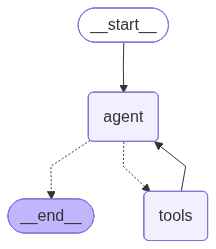

In [31]:
agent

### Key Takeaway:
- `create_agent()` builds a complete agent in ~10 lines
- The agent automatically handles the reasoning → action → observation loop
- Built on LangGraph for production features (persistence, streaming, human-in-the-loop)

## Part 5: Adding Memory & State

Right now, each agent invocation is independent. Let's add **memory** so the agent can maintain context across multiple interactions.

LangGraph uses **checkpointers** to save and restore state:

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
import uuid

# Create a checkpointer for memory
checkpointer = MemorySaver()

# Create an agent with memory
agent_with_memory = create_agent(
    model="openai:gpt-4o-mini",
    tools=[get_weather, search_movies],
    system_prompt="You are a helpful assistant.",
    checkpointer=checkpointer
)

# Create a thread for this conversation
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

# First interaction
result1 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "My name is Alice and I love sci-fi movies."}]},
    config=config
)

print("Response 1:", result1["messages"][-1].content)

# Second interaction - the agent remembers!
result2 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "What's my name and what movies do I like?"}]},
    config=config
)
print("\nResponse 2:", result2["messages"][-1].content)

Response 1: Nice to meet you, Alice! Since you love sci-fi movies, would you like me to find some recommendations for you?

Response 2: Your name is Alice, and you love sci-fi movies. Would you like me to find some sci-fi movie recommendations for you?


### Understanding State & Threads

- **State**: The agent's "memory" - includes message history and any custom data
- **Thread**: A conversation session identified by `thread_id`
- **Checkpointer**: Saves state after each step, enabling memory and error recovery

Each thread is independent:

In [33]:
# New thread - agent won't remember Alice
new_thread_id = str(uuid.uuid4())
new_config = {"configurable": {"thread_id": new_thread_id}}

result3 = agent_with_memory.invoke(
    {"messages": [{"role": "user", "content": "What's my name?"}]},
    config=new_config
)
print("New thread response:", result3["messages"][-1].content)

New thread response: I don't know your name. If you'd like to share it with me, feel free!


### Key Takeaway:
- Checkpointers enable memory across interactions
- Thread IDs separate different conversations
- State persists automatically - no manual state management needed!

## Part 6: Streaming for Better UX

LLMs can take a while to respond. **Streaming** shows progress in real-time, dramatically improving user experience.

LangChain supports multiple streaming modes:

### Streaming Agent Steps

In [34]:
# Stream agent progress with stream_mode="updates"
print("Streaming agent steps:\n")

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "What's the weather in Boston?"}]},
    stream_mode="updates"
):
    for node_name, data in chunk.items():
        print(f"Step: {node_name}")
        if "messages" in data:
            message = data["messages"][-1]
            if hasattr(message, 'tool_calls') and message.tool_calls:
                print(f"   Tool call: {message.tool_calls[0]['name']}")
            elif hasattr(message, 'content'):
                print(f"   Content: {message.content[:100]}..." if len(message.content) > 100 else f"   Content: {message.content}")
        print()

Streaming agent steps:

Step: agent
   Tool call: get_weather

Step: tools
   Content: {"temperature_fahrenheit": 82.5, "weather_code": 0}

Step: agent
   Content: Boston right now is about 82.5°F with clear skies. Would you like a movie recommendation to match th...



### Streaming LLM Tokens

For a ChatGPT-like experience, stream tokens as they're generated:

In [35]:
# Stream tokens with stream_mode="messages"
print("Streaming tokens:\n")

for token, metadata in agent.stream(
    {"messages": [{"role": "user", "content": "Tell me about LangGraph in one sentence."}]},
    stream_mode="messages"
):
    # Only print content from the agent node
    if metadata.get('langgraph_node') == 'agent':
        # Get text from content blocks
        for block in token.content_blocks:
            if block.get('type') == 'text' and block.get('text'):
                print(block['text'], end='', flush=True)

print("\n")  # New line at the end

Streaming tokens:

Could you clarify which LangGraph you mean (e.g., a software library, a research project, or a specific product) so I can describe it accurately in one sentence?



### Key Takeaway:
- `stream_mode="updates"` - See each agent step (useful for debugging)
- `stream_mode="messages"` - Stream LLM tokens (ChatGPT-like UX)
- Streaming is built-in - no extra setup required!

## Part 7: Putting It All Together - A Practical Example

Let's build a more realistic agent that combines everything we've learned:

In [ ]:
# Create more realistic tools
@tool
def get_user_preferences(user_id: str) -> str:
    """Get a user's saved preferences."""
    # Simulate a user database
    preferences = {
        "alice": "Loves sci-fi movies, prefers warm weather destinations",
        "bob": "Enjoys comedy films, likes cold climates for travel"
    }
    return preferences.get(user_id.lower(), "No preferences found")

@tool
def book_recommendation(genre: str, user_preferences: str = "") -> str:
    """Get personalized movie recommendations based on genre and user preferences."""
    recommendations = {
        "sci-fi": "Based on your preferences, try: Arrival, Ex Machina, or The Martian",
        "comedy": "Based on your preferences, try: The Big Lebowski, Anchorman, or Bridesmaids"
    }
    return recommendations.get(genre.lower(), "No recommendations available")

# Create a helpful assistant agent
assistant = create_agent(
    model="openai:gpt-5-nano",
    tools=[get_weather, get_user_preferences, book_recommendation],
    system_prompt="""You are a helpful personal assistant. 
    
    You can:
    - Check weather for any city
    - Look up user preferences
    - Recommend movies based on preferences
    
    Always be friendly and personalize your responses based on user preferences.""",
    checkpointer=MemorySaver()
)

# Demo conversation
thread_id = str(uuid.uuid4())
config = {"configurable": {"thread_id": thread_id}}

print("=" * 50)
print("PERSONAL ASSISTANT DEMO")
print("=" * 50 + "\n")

# Interaction 1
print("User: Hi, I'm Alice. Can you check my preferences and recommend a movie?\n")
result = assistant.invoke(
    {"messages": [{"role": "user", "content": "Hi, I'm Alice. Can you check my preferences and recommend a movie?"}]},
    config=config
)
print(f"Assistant: {result['messages'][-1].content}\n")

# Interaction 2
print("User: Also, what's the weather like in San Francisco?\n")
result = assistant.invoke(
    {"messages": [{"role": "user", "content": "Also, what's the weather like in San Francisco?"}]},
    config=config
)
print(f"Assistant: {result['messages'][-1].content}\n")

print("=" * 50)

PERSONAL ASSISTANT DEMO

User: Hi, I'm Alice. Can you check my preferences and recommend a movie?

Assistant: Hi Alice! Nice to meet you.

I pulled up your saved preferences: you love sci-fi movies and you prefer warm-weather destinations.

I tried to fetch a tailored pick from my recommender, but it didn’t return a specific title this time. In the meantime, here are some strong sci-fi picks that fit a warm/tropical vibe:

- Avatar (2009) — lush, tropical world with stunning visuals and big sci-fi adventure.
- Jurassic Park (1993) — a classic on a tropical island; perfect blend of science fiction and thrilling action.
- Jurassic World (2015) — modern take on the island-resort idea with plenty of sun-soaked settings.
- Dune (2021) — desert heat and epic sci-fi drama for a grand, sun-baked atmosphere.

Would you like me to check streaming availability for any of these, or tailor further (e.g., more action-heavy, lighter tone, or runtime preferences)?

User: Also, what's the weather like 

## Part 8: Next Steps - Exploring LangGraph Primitives

We've been using `create_agent()`, which is built on **LangGraph**. LangGraph gives you full control over agent behavior using three core primitives:

### Core LangGraph Concepts:

1. **State** 
   - Shared data structure passed between nodes
   - Represents the agent's "memory"
   - Can include messages, custom data, etc.

2. **Nodes** 
   - Python functions that process state
   - Each node performs a specific task
   - Examples: call LLM, execute tool, validate input

3. **Edges** 
   - Define flow between nodes
   - Can be normal (always go to next node)
   - Or conditional (decide based on logic)

### When to use `create_agent()` vs custom LangGraph?

**Use `create_agent()` when:**
- Building standard ReAct-style agents
- You need quick prototyping
- Default behavior works for your use case

**Use custom LangGraph when:**
- You need custom control flow (e.g., approval workflows)
- Building multi-agent systems
- Implementing human-in-the-loop patterns
- Complex state management requirements

For more advanced patterns, check out:
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangChain Academy](https://academy.langchain.com/)
- The `multi_agent.ipynb` notebook in this repo (LangGraph 201)

## 🎉 Congratulations!

You've learned the core concepts of building agents with LangChain and LangGraph:

 **Models** - Standardized interface across providers  
 **Messages** - Building block of conversations  
 **Tools** - Extending LLM capabilities  
 **Agents** - Automated reasoning and action loops  
 **Memory** - Maintaining context across interactions  
 **Streaming** - Real-time user experience  
 **LangGraph** - The foundation powering it all

### What's Next?

1. **Build your own agent** with your specific tools and use case
2. **Explore advanced patterns** in the `multi_agent.ipynb` notebook
3. **Add debugging** with [LangSmith](https://smith.langchain.com)
4. **Deploy to production** using LangGraph's persistence and error recovery

### Resources:

- [LangChain Documentation](https://python.langchain.com/docs/introduction/)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [LangSmith for Debugging](https://smith.langchain.com)
- [LangChain Academy](https://academy.langchain.com/)
<br> 
<br> 
---
<br> 

**Happy building!**